### **2D Power Spectrum Calculation Example:**

This notebook features an example calculation of the 2D power spectrum using the *baseDC2_snapshot_z0.15_v0.1* catalog

#### **Import Files and Setup Configuration:**

In [1]:
import GCRCatalogs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys

from halotools.mock_observables import apply_zspace_distortion
from scipy.constants import speed_of_light
from scipy.stats import chi2 as chi2func

sns.set(style = "ticks")
pi = np.pi

# Load Appropriate Catalog
#cat = GCRCatalogs.load_catalog("baseDC2_snapshot_z0.15_v0.1_small")
cat = GCRCatalogs.load_catalog("baseDC2_snapshot_z0.15_v0.1")

#### **Load Position Data and Apply Preliminary Cuts:**

Load the data appropriately depending on user-defined cuts. X and Y positions are cut equally to define a square 2D grid (position data limits are listed below). Additionally, removes all galaxies with $r_{mag} > 24.5$.

**Small Catalog Limits\*:**

| X | Y | Z |
| --- | --- | --- |
| [0, 354.7] | [0, 425.0] | [0, 846.5] |

**Full Catalog Limits:**

| X | Y | Z |
| --- | --- | --- |
| [0, 4231.7] | [0, 4232.25] | [0, 4231.6] |

\* The small catalog has 40 positional entries with X, Y, or Z around 4000 Mpc, but after removing these entries, the above boundaries are identified.

In [2]:
# Initialize/Load Cosmology Parameters
z_red_shift = cat.redshift
cosmo = cat.cosmology # astropy cosmology object
h = cosmo.h

#Initialize a PyCCL cosmology object for future calculations
cosmo_ccl = pyccl.Cosmology(h = cosmo.h, sigma8 = cosmo.sigma8, 
                            Omega_g = cosmo.Ogamma0, Omega_k = cosmo.Ok0, 
                            Omega_c =  cosmo.Odm0, Omega_b = cosmo.Ob0, 
                            n_s = cosmo.n_s, Neff = cosmo.Neff)


# Setup box bounds (Mpc) 

# Not loading full z window to save time is justified since Gaussian kernel 
# will select window of around 2000 Mpc)
min_z = 1000
max_z = 3000
min_x_y = 0
max_x_y = 4232

# min_z = 0
# max_z = 800
# min_x_y = 0
# max_x_y = 350

print("Loading quantitites")
cat_quantities = cat.get_quantities(["position_x", "position_y", "position_z", 
                                     "Mag_true_r_lsst_z0"], 
                                    filters=["position_z > {}".format(min_z), 
                                             "position_z < {}".format(max_z), 
                                             "position_x < {}".format(max_x_y),
                                             "position_x > {}".format(min_x_y),
                                             "position_y < {}".format(max_x_y),
                                             "position_y > {}".format(min_x_y)])


print("Selecting appropriate quantity region")

# Convert absolute to apparent magnitude
r_Mag = cat_quantities["Mag_true_r_lsst_z0"]
r_mag = r_Mag+cosmo.distmod(z_red_shift).value  
filtered_indices = np.where(r_mag < 24.5)[0]

# Clear magnitude arrays
del r_mag
del r_Mag

# Account for peculiar velocity redshift distortions
x_data = cat_quantities["position_x"][filtered_indices]
y_data = cat_quantities["position_y"][filtered_indices]
z_data = cat_quantities["position_z"][filtered_indices]

del cat_quantities

Loading quantitites
Selecting appropriate quantity region


#### **Filter Position Data with Gaussian Kernel:**

Apply a Gaussian kernel to the z position data and then select galaxies acccording to a Gaussian kernel defined as $e^{-\frac{(z-\bar{z})^2}{2\sigma_\chi^2}}$, where $\bar{z}$ is the average z position, $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$.

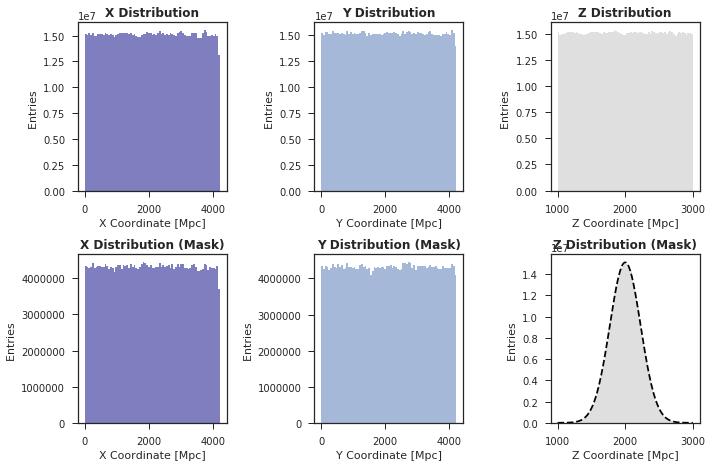

In [3]:
# Compute standard deviations for establishing Gaussian
sigma_z = 0.05*(1+z_red_shift)
H_z = cosmo.H(z_red_shift).value
c_km_s = speed_of_light/10**3 # speed of light in km/s
sigma_chi = c_km_s/H_z*sigma_z


# Apply Gaussian kernel
z_bar = np.mean(z_data)
cutoffs = np.random.uniform(0, 1, len(z_data))

mask_ind = np.where(cutoffs < np.exp(-(z_data-z_bar)**2/(2*sigma_chi**2)))[0]

x_masked = x_data[mask_ind]
y_masked = y_data[mask_ind]
z_masked = z_data[mask_ind]

# Calculate galaxy density
n_bar = len(x_masked)/(max_x_y-min_x_y)**2


#----------------------------Begin Plotting----------------------------#
# Plot masked and unmasked histograms
fig = plt.figure(figsize=(10,6.6))
n_bins = 75

plt.subplot(2,3,1)
plt.hist(x_data, bins = n_bins, alpha  = 0.5, color = "navy")
plt.title("X Distribution", fontweight = "bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,2)
plt.hist(y_data, bins = n_bins, alpha = 0.5);
plt.title("Y Distribution", fontweight = "bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,3)
plt.hist(z_data, bins = n_bins, alpha = 0.5, color = "silver");
plt.title("Z Distribution", fontweight = "bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,4)
plt.hist(x_masked, bins = n_bins, alpha  = 0.5, color = "navy")
plt.title("X Distribution (Mask)",fontweight = "bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,5)
plt.hist(y_masked, bins = n_bins, alpha = 0.5);
plt.title("Y Distribution (Mask)", fontweight = "bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,6)
plt.hist(z_masked, bins = n_bins, alpha = 0.5, color = "silver");
plt.title("Z Distribution (Mask)", fontweight = "bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")

sigma_chi_str = "$\sigma_\chi$ = {}".format(np.round(sigma_chi, 1))

# Overlay Gaussian
z_gaussian = np.linspace(min_z, max_z, 200)
exp_z = 1/(np.sqrt(2*pi)*sigma_chi)*np.exp(-(z_gaussian-z_bar)**2/(2*sigma_chi**2))

bin_width = (max_z - min_z)/n_bins

# Rescale by accounting for the fact that the data do not fulfill the entire Gaussian 
# and by multiplying the normalized pdf by bin_width*len(data)
std_offset = (max_z-min_z)/(2*sigma_chi)
rel_area = scipy.stats.norm.cdf(std_offset)-scipy.stats.norm.cdf(-std_offset)
exp_z *= (bin_width*len(z_masked))/rel_area

plt.plot(z_gaussian, exp_z, '--', color = 'k')

plt.tight_layout()

#### **Get Matter Power-Spectrum From Data:**

Code cell below defines a method for calculating the 2D power spectrum for x and y data with a specified resolution size *N* by computing the over-density field, 2-point correlation function, and then applying a 2D FFT. Additionally, a method is defined for averaging power spectrum values in bins of wavenumbers.

In [4]:
def calculate_pow_spec(x_data, y_data,  N):
    
    """ Calculates the 2D power spectrum from data with specified grid size.
    
    
    Parameters:
    x_data (np float array): Array containing x positions of galaxies in Mpc
    y_data (np float array): Array containing y positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spectrum calculation
    
    Returns:
    delta_k (np 2d float array): 2D array representing the over-density field
    k_vals (np float array): array containing the returned wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values
    """
    
    x_min = np.floor(x_data.min())
    x_max = np.ceil(x_data.max())
    x_width = x_max-x_min

    y_min = np.floor(y_data.min())
    y_max = np.ceil(y_data.max())
    y_width = x_width
    
    # Initialize Grid
    grid_matrix = np.histogram2d(x_data, y_data, N)[0]
    
    # Get the number of galaxies and set amount of data points per bin
    n_g = len(x_data)
    p_bin = (int) (n_g/10000) 
    
    delta_x = x_width/N
    delta_y = y_width/N
               
    # Convert grid to represent over_density
    p_bar = n_g/N**2 # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat) 

    # Compute variance in delta for cross-checking
    var_delta = np.var(delta.flatten())

    #Get frequency values
    f_value = np.fft.fftfreq(N)
    kx_mat = np.outer(np.ones(N), 2.0*pi*f_value/delta_x)
    ky_mat = np.outer(2.0*pi*f_value/delta_y, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kx_mat**2+(ky_mat)**2)

    # Perform fourier transform
    delta_k = np.fft.fft2(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))
    p_k = pow_spec.flatten()/(N**2*N**2/(x_width*y_width))


    # Construct and rescale wave number axis
    k_vals = k_mat.flatten()
    k_vals = k_vals[0:len(p_k)]
    
    # Remove zero order mode
    return delta, k_vals, p_k

def average_data(k_vals, p_vals, n_bins):
    """ Averaged power spectrum and wave numbers into ~n_bins (averaging is not 
    always exact since empty bins are removed)
    
    Parameters:
    k_vals (np float array): Array containing wave numbers in Mpc^-1
    p_vals (np float array): Array containing power spectrum associated with k_vals
    n_bins (int): Integer representing the desired number of bins to average into
    
    Returns:
    averaged_k (np float array): arrray containing averaged wave numbers
    averaged_p (np float array): array containing the averaged power spectrum
    N_modes (np int array): array containing the number of data points in each k bin
    """
    
    # Sort power spectrum by k
    k_p_k = (np.vstack((k_vals, p_vals))).T
    k_p_k = k_p_k[k_p_k[:,0].argsort()]

    # Extract sorted values
    k_vals = k_p_k.T[0]
    p_k = k_p_k.T[1]
    
    n_modes, hist_bins = np.histogram(k_vals, bins= n_bins)
    averaged_k = hist_bins+hist_bins[1]/2 # Get average wavenumber of each bin
    averaged_k = averaged_k[0:n_bins] # Remove last bin since this is just upper limit
    averaged_p = np.zeros_like(averaged_k) # Construct array for power spectrum values 

    # Remove bins with no modes
    averaged_k = averaged_k[np.where(n_modes != 0)]
    averaged_p = averaged_p[np.where(n_modes!=0)]
    n_modes = n_modes[np.where(n_modes!=0)]
    
    low_ind = 0
    
    # Fill each averaged power spectrum bin
    for ind, n_mode in enumerate(n_modes):
        averaged_p[ind] = np.mean(p_k[low_ind:low_ind+n_mode])
        low_ind += n_mode

    return averaged_k, averaged_p, n_modes

def progressBar(cur_val, final_val):
    """ Simple function to keep track of progress in computations
    
    Parameters:
    cur_val (int/float): Current value that calculation is on (normally iteration index)
    final_val (int/float): Final value that calculation will take (normally num. iterations) 
    """
    bar_length=20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'        
    spaces = ' ' * (bar_length - len(arrow))
    
    sys.stdout.write("\rProgress: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush() 

#### **Compute and Average Power Spectrum Over a Range of N:**

Calculate the power spectrum for an array of resolutions to get an estimate over a larger range of wavenumbers and averages the results after calculation in bins of wavenumber.

In [5]:
# Array of dimensions, N, to compute the power spectrum over 
n_range = 2**np.arange(6, 12)

# Construct arrays to store total data from each grid size
k_bar_total = np.array([])
p_k_bar_total = np.array([])
var_p_k_bar_total = np.array([])
n_modes_total = np.array([])

for i, n in enumerate(n_range):
    
    # Updat progress
    progressBar(i, len(n_range))  
    
    delta, k_bar, p_k_bar = calculate_pow_spec(x_masked, y_masked,  n)
    k_bar_total = np.append(k_bar_total, k_bar)
    p_k_bar_total = np.append(p_k_bar_total, p_k_bar)
    
    # Update progress
    progressBar(i+1, len(n_range))

# Re-average Data
n_bins = 512
k_bar_avg, p_k_bar_avg, n_modes_avg = average_data(k_bar_total, p_k_bar_total, n_bins)

# Remove zero order mode
k_bar_avg = k_bar_avg[1:]
p_k_bar_avg = p_k_bar_avg[1:]
n_modes_avg = n_modes_avg[1:]


Progress: [------------------->] 100%

#### **Compute 2D Power Spectrum Projections:**

Code cell below defines a series of methods to construct the 2D power spectrum from CCL models using the following procedure:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear matter p
ower spectrum function in pyCCL
2. Integrate over a range of values for $k_\perp$ using the integral defined below to obtain a theoretical estimate for the 2D matter power spectrum
$$P_{matter}(k_\perp) = \frac{1}{2\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel$$
3. Get 2D galaxy power spectrum using the following model:
$$P_{gal}(k_\perp) = b_1^2P_{matter}(k_\perp)+\frac{1}{\bar{n}}$$

In [6]:
def integrand_function(k_par, k_perp, cosmo_ccl, cosmo, z, sigma_chi, linear):
    """ Returns the computed integrand (P(k_par,k_perp)exp(-k_par^2*sigma_chi^2)). 
    where P(k_par, k_perp) is computed using either teh Pyccl linear or non-linear
    matter power spectrum depending on input
    
    Parameters:
    k_par (float): Parallel wave number to be integrated over numerically
    k_perp (np float array): Array containing the perpendicular wave numbers
    cosmo_ccl (pyccl cosmology) : pyccl cosmology object used for calculating power spectrum
    cosmo (astropy cosmology): astropy cosmology object used to get the scale factor 
    z (float): redshift value of the catalog used to compute the scale factor
    sigma_chi (float): sigma_chi used in Gaussian kernel
    linear (bool): boolean represented whether to use linear or non-linear model
    
    Returns:
    float representing the calcualted integrand value
    """
    
    if linear:
        P_k = pyccl.linear_matter_power(cosmo_ccl, np.sqrt(k_perp**2+k_par**2), 
                                    cosmo.scale_factor(z))
    else:
        P_k = pyccl.nonlin_matter_power(cosmo_ccl, np.sqrt(k_perp**2+k_par**2), 
                                    cosmo.scale_factor(z))
        
    return P_k*np.exp(-(k_par*sigma_chi)**2)


# Define linear and non-linear functions to compute integral
integrator = np.vectorize(lambda k_perp: 1/(2*pi)*scipy.integrate.quad(
    integrand_function, 0, 0.3, args=(k_perp, cosmo_ccl, cosmo, 
                                      z_red_shift, sigma_chi, True))[0])

integrator_nl = np.vectorize(lambda k_perp: 1/(2*pi)*scipy.integrate.quad(
    integrand_function, 0, 0.3, args=(k_perp, cosmo_ccl, cosmo, 
                                      z_red_shift, sigma_chi, False))[0])


def get_pow_2d(k_perp, integrator, b_1, n_bar):
    """Function to get the 2D galaxy power spectrum using the following model:
    P_gal = b_1^2*P_matter+1/n_bar
    
    Parameters:
    k_perp (np float array): Array containing the perpendicular wave numbers
    integrator (vectorized function): function to compute integral using linear or
    non-linear power spectrum
    b_1 (float): bias term 
    n_bar (float): average galaxy density to account for shot-noise
    
    Returns:
    np float array representing the 2D power spectrum calculated over a given k_perp
    """
    
    return b_1**2*integrator(k_perp)+1/n_bar




#### **Plot 2D Power Spectrum Data and Models:**

Plots the averaged 2D power spectrum data with appropriately fit models ($P_{gal}(k_\perp) = b_1^2P_{matter}+\frac{1}{\bar{n}}$)

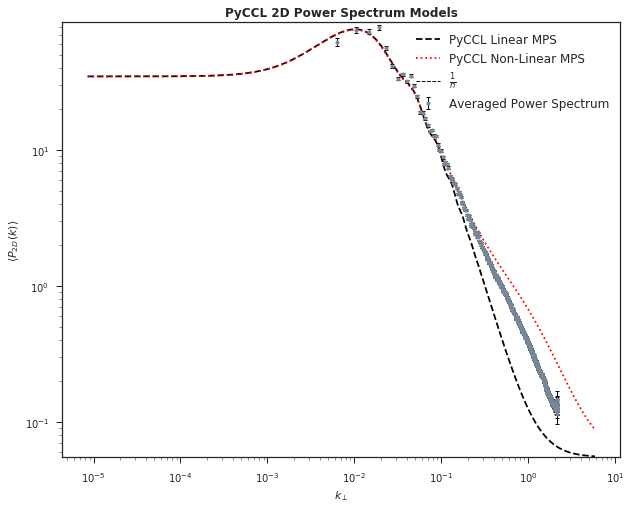

In [7]:
# Select a bias term b_1 for the modle P_gal = b_1^2*P_matter+1/n_bar
b_1 = np.sqrt(1.74)

# Compute average variance in the data
var_p_k_bar_avg = 2*p_k_bar_avg**2/n_modes_avg

# Plot data for 2D linear and non-linear full range approx.
plt.figure(figsize = (10,8))
k_theoretical = np.logspace(np.log(np.min(k_bar_avg)), 
                            np.log(np.max(k_bar_avg)), 512)
plt.plot(k_theoretical, get_pow_2d(k_theoretical, integrator, b_1, n_bar), 
         color = "k",  linestyle  = "dashed",label = "PyCCL Linear MPS")

plt.plot(k_theoretical, get_pow_2d(k_theoretical, integrator_nl, b_1, n_bar), 
         color = "r" , linestyle = ":",label = "PyCCL Non-Linear MPS")

plt.errorbar(k_bar_avg, p_k_bar_avg, yerr=np.sqrt(var_p_k_bar_avg), marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1,
             label = "Averaged Power Spectrum")
plt.ylim(bottom = 1/n_bar)


plt.hlines(1/n_bar, 0, np.max(k_bar_avg), label = r"$\frac{1}{n}$", linewidth = 1, linestyle = "dashed")

plt.title("PyCCL 2D Power Spectrum Models", fontweight = "bold")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle$")
plt.legend(loc = "upper right", fontsize = 12) 
plt.xscale("log")
plt.yscale("log")


plt.savefig("deviations.png", dpi=600)

#### **Fit Power Spectrum with Single Paramater:**

Determines the optimal parameter $b_1$ to fit the power spectrum upto varying $k_\perp^{max}$ with the following relationship:
$$P_{gal}(k_\perp) = b_1^2P_{matter}+\frac{1}{\bar{n}}$$


Maximizes the following log-likelihood expression
* $\log{(Likelihood)} = -(\frac{\chi^2}{2}+ \sum\limits_{i=1}^{nbins} \log{(\sigma_i}))$
* $ \chi^2= \sum\limits_{nbins} \frac{(P_{theory}(k_\perp) - P_{data}(k_\perp))^2}{\sigma^2}$
* $\sigma = P_{theory}(k_\perp)\sqrt\frac{2}{Nmodes}$

Compute cdf for the best fit $\chi^2$,  given degrees of freedom, where d.o.f. = N_bins - 1

In [8]:
# Optimal solution guess
b_1_guess = np.sqrt(1.5)


# CURRENTLY USING VARIANCE FROM DATA, TO USE CALCULATED VARIANCE CHANGE VAR_E TO VAR_T
# IN CALC_CHI_SQ FUNCTION AND NEG_LOG_LIKE FUNCTION

def calc_chi_sq(b_1, k, p_k, N_modes, var_e, integrator, n_bar):
    """Computes the total chi squared value for a given set of data and parameters:
    
    Parameters:
    b_1 (float): bias term over which we can minimize this function
    k (np float array): Array containing the perpendicular wave numbers
    p_k (np float array): Array containing power spectrum associated with k_vals
    N_modes (np int array): Array containing the number of Fourier modes in each k bin
    var_e (np float arary): Array containing the experimental variance from the data
                            will be removed once theoretical variance is figured out
    integrator (vectorized function): function to compute integral using linear or
    n_bar (float): average galaxy density to account for shot-noise
    
    Returns:
    float representing the summed chi_sq values
    """
    
    p_theory = get_pow_2d(k, integrator, b_1, n_bar)
    var_t = 2*p_theory**2/N_modes # Compute the theoretical variance
    chi_sq_arr = (p_k-p_theory)**2/var_e
    
    return np.sum(chi_sq_arr)

def neg_log_like(b_1, k, p_k, integrator, n_bar, N_modes, var_e):
    """Computes the total negative log likelihood for a given set of paramater/dat:
    
    Parameters:
    b_1 (float): bias term over which we can minimize this function
    k (np float array): Array containing the perpendicular wave numbers
    p_k (np float array): Array containing power spectrum associated with k_vals
    integrator (vectorized function): function to compute integral using linear or
    n_bar (float): average galaxy density to account for shot-noise
    N_modes (np int array): Array containing the number of Fourier modes in each k bin
    var_e (np float arary): Array containing the experimental variance from the data
                            will be removed once theoretical variance is figured out
    
    
    Returns:
    float representing the total negative log likelihood
    """
    
    # Compute theoretical variance
    p_theory = get_pow_2d(k, integrator, b_1, n_bar)
    var_t = 2*p_theory**2/N_modes
    
    # Compute chi_sq
    chi_sq = np.sum((p_k-p_theory)**2/var_e)
    
    log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_e)))
    
    return chi_sq
    
# Create array of k max values to optimize upto
k_max_arr = np.linspace(0.05, 0.8, 30)

# Create empty arrays to fill with optimal parameters
b_vals = np.zeros_like(k_max_arr)
log_like_vals = np.zeros_like(k_max_arr)
chi_sq_vals = np.zeros_like(k_max_arr)

for ind, k_max in enumerate(k_max_arr):
    progressBar(ind, len(k_max_arr))  
    
    # Pick appropriate subset of values less than k_max_arr
    subset_indices = np.where(k_bar_avg < k_max)
    k_subset = k_bar_avg[subset_indices]
    p_k_subset = p_k_bar_avg[subset_indices]
    var_subset = var_p_k_bar_avg[subset_indices]
    n_modes_subset = n_modes_avg[subset_indices]
    
    # Maxmize log likelihood
    res = scipy.optimize.minimize(neg_log_like, b_1_guess, method='SLSQP',
                     args=(k_subset, p_k_subset,integrator, n_bar, n_modes_subset, var_subset),
                                     bounds=[(0, None)])

    
    # Fill arrays
    log_like_vals[ind] = res.fun
    b_vals[ind] = res.x[0]
    chi_sq_vals[ind] = calc_chi_sq(res.x[0], k_subset, p_k_subset, n_modes_subset, var_subset, 
                                 integrator, n_bar)
    
    progressBar(ind+1, len(k_max_arr))
    

# Calculate cdf
cdf = chi2func.cdf(chi_sq_vals, df = len(k_bar_avg)-1)

Progress: [------------------->] 100%

#### **Best Fit Plots:**

Make various plots about the best fit data


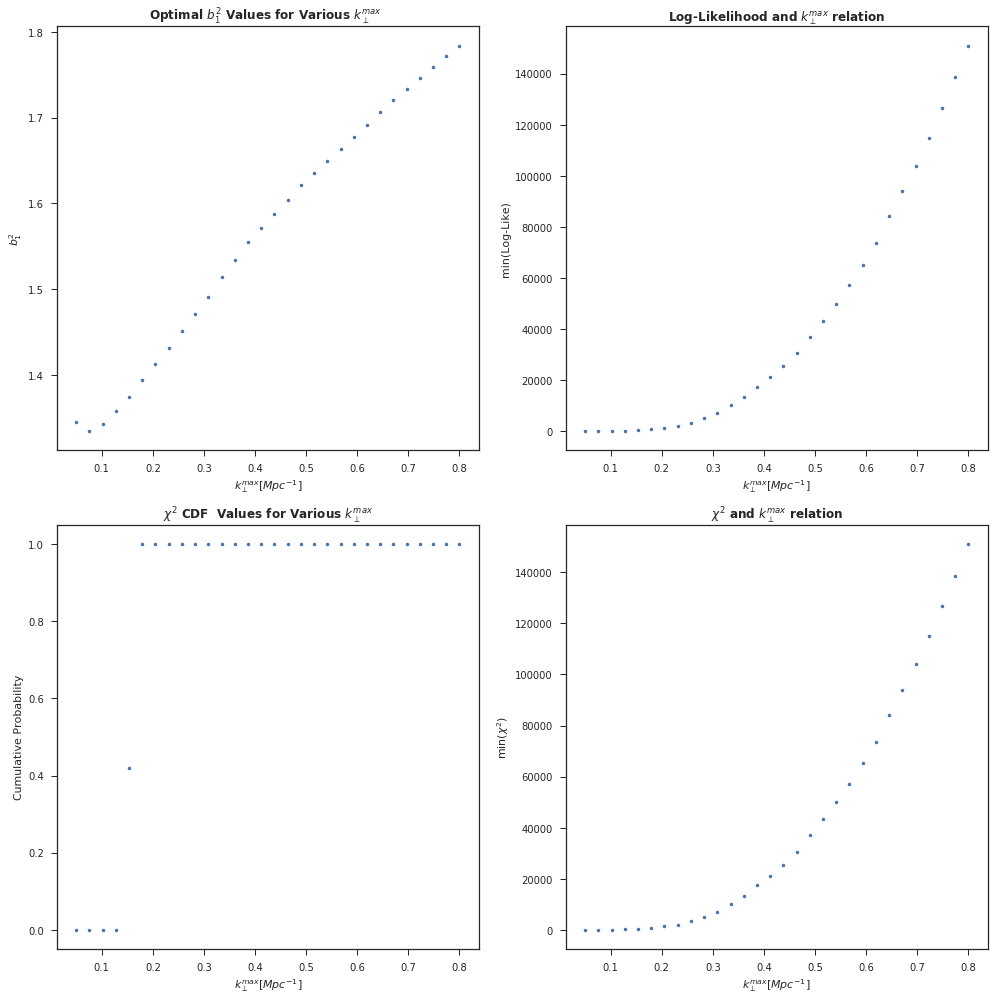

In [9]:
plt.figure(figsize = (14,14))
plt.subplot(2,2,1)
plt.plot(k_max_arr, b_vals, '.')
plt.title(r"Optimal $b_1^2$ Values for Various $k_\perp^{max} $  ", fontweight = "bold")
plt.xlabel("$k_\perp^{max} [Mpc^{-1}]$")
plt.ylabel("$b_1^2$")


plt.subplot(2,2,2)
plt.plot(k_max_arr, log_like_vals, '.')
plt.title(r"Log-Likelihood and $k_\perp^{max}$ relation", fontweight = "bold")
plt.ylabel(r"min(Log-Like)")
plt.xlabel(r"$k_\perp^{max} [Mpc^{-1}] $")

plt.subplot(2,2,3)
plt.plot(k_max_arr, cdf, '.')
plt.title(r"$\chi^2$ CDF  Values for Various $k_\perp^{max}$", fontweight = "bold")
plt.xlabel("$k_\perp^{max} [Mpc^{-1}]$")
plt.ylabel("Cumulative Probability")


plt.subplot(2,2,4)
plt.title(r"$\chi^2$ and $k_\perp^{max}$ relation", fontweight = "bold")
plt.ylabel(r"min($\chi^2$)")
plt.xlabel(r"$k_\perp^{max} [Mpc^{-1}] $")
plt.plot(k_max_arr, chi_sq_vals, '.')

plt.tight_layout()
plt.savefig("optimal_b_chisq_min.png", dpi=600)
